In [1]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input
from keras import backend as K
import tensorflow as tf
tf.test.gpu_device_name()


2022-11-25 17:03:00.886575: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 17:03:00.954454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 17:03:00.960033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 17:03:00.960194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

'/device:GPU:0'

Downloading and loading the data

In [2]:
# !wget 'https://surfdrive.surf.nl/files/index.php/s/B8emtQRGUeAaqmz/download'

# !mv download a2_data.zip

# !yes | unzip a2_data.zip

# !rm a2_data.zip

In [3]:
images = np.load("images.npy")
labels = np.load("labels.npy")


Splitting the data into training and testing sets

In [4]:
# Randomize and split data
p = np.random.RandomState(seed=42).permutation(len(labels))
images = images[p]
labels = labels[p]

#images = np.expand_dims(images, axis=-1)

images = images.astype('float32')
images /= 255

split_idx = int(len(images)*0.8)

#print(labels[5432:5472])

In [5]:
# Regression
reg_labels = np.zeros(len(images))
reg_labels = labels[:, 0] + labels[:, 1]/60.0

train_images = images[:split_idx]
train_labels = labels[:split_idx]

test_images = images[split_idx:]
test_labels = labels[split_idx:]



Defining the common sense accuracy. The class is to be used as a loss function for training, while the clock_loss_np is for evaluating the accuracy after training.

In [6]:
class ClockLossAccuracy(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
  '''def call2(self, y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_pred-y_true))
    rmse = tf.math.sqrt(mse)
    return rmse / tf.reduce_mean(tf.square(y_true)) - 1'''

  def call(self, y_true, y_pred):
    y_pred = y_pred % 12.0
    res = tf.math.abs(y_true - y_pred)
    #tf.print(res)
    res2 = tf.math.minimum(res, 12.0 - res)
    #tf.print(res2)
    res3 = tf.square(res2)
    return tf.reduce_mean(res3, axis=-1)

In [7]:
def clock_loss_np(y_true, y_pred):
    res = np.abs(y_true - y_pred)
    res = np.minimum(res, 12.0 - res)
    return np.mean(res)


# Regression

## Using MeanSquaredError as loss function

In [8]:
#Regression with MeanSquaredError()

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))



#model.compile(loss=clock_loss,
model.compile(loss=tf.keras.losses.MeanSquaredError(),#ClockLossAccuracy(),
    optimizer=keras.optimizers.RMSprop(),
    metrics=['mae'])

model.fit(images[:split_idx], reg_labels[:split_idx],
    batch_size=100,
    epochs=60,
    verbose=1,
    validation_data=(images[split_idx:], reg_labels[split_idx:]))

print(model.summary())

score = model.evaluate(images[split_idx:], reg_labels[split_idx:])
print(score)


2022-11-25 15:55:47.235052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 15:55:47.235218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 15:55:47.235318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 15:55:47.235550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 15:55:47.235658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Epoch 1/60


2022-11-25 15:55:49.448939: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-11-25 15:55:50.093191: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 15:55:50.095288: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 15:55:50.095312: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-25 15:55:50.095790: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 15:55:50.095911: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-25 15:55:50.692121: I tensorflow/stream_executor/cuda/c

144/144 [==============================] - 6s 22ms/step - loss: 14.5999 - mae: 3.2151 - val_loss: 12.3529 - val_mae: 3.0259
Epoch 2/60
144/144 [==============================] - 3s 20ms/step - loss: 12.7276 - mae: 3.0168 - val_loss: 12.7785 - val_mae: 2.9756
Epoch 3/60
144/144 [==============================] - 3s 20ms/step - loss: 11.0661 - mae: 2.7380 - val_loss: 10.5189 - val_mae: 2.6055
Epoch 4/60
144/144 [==============================] - 3s 20ms/step - loss: 10.1524 - mae: 2.5755 - val_loss: 9.4124 - val_mae: 2.4717
Epoch 5/60
144/144 [==============================] - 3s 21ms/step - loss: 9.6014 - mae: 2.4916 - val_loss: 8.9378 - val_mae: 2.3637
Epoch 6/60
144/144 [==============================] - 3s 20ms/step - loss: 8.7762 - mae: 2.3649 - val_loss: 8.0088 - val_mae: 2.2354
Epoch 7/60
144/144 [==============================] - 3s 20ms/step - loss: 8.0708 - mae: 2.2484 - val_loss: 7.5643 - val_mae: 2.1439
Epoch 8/60
144/144 [==============================] - 3s 21ms/step - loss

 conv2d (Conv2D)             (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 flatten (

In [9]:
predictions=model.predict(images[:split_idx]) % 12
print(f'Accuracy for training Set {clock_loss_np(reg_labels[:split_idx],predictions.reshape((len(predictions))))}')
print(f'in minutes {clock_loss_np(reg_labels[:split_idx],predictions.reshape((len(predictions))))*60}')

predictions=model.predict(images[split_idx:]) % 12
print(f'Accuracy for testing Set {clock_loss_np(reg_labels[split_idx:],predictions.reshape((len(predictions))))}')
print(f'in minutes {clock_loss_np(reg_labels[split_idx:],predictions.reshape((len(predictions))))*60}')


2022-11-25 15:58:50.849128: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.
2022-11-25 15:58:51.399327: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.


Accuracy for training Set 0.22403436338639368
in minutes 13.442061803183622
Accuracy for testing Set 0.7943823396491784
in minutes 47.6629403789507


## Using ClockLossAccuracy as loss function

In [10]:
#Regression with ClockLossAccuracy()

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))



#model.compile(loss=clock_loss,
model.compile(loss=ClockLossAccuracy(),
    optimizer=keras.optimizers.RMSprop(),
    metrics=['mae'])

model.fit(images[:split_idx], reg_labels[:split_idx],
    batch_size=100,
    epochs=60,
    verbose=1,
    validation_data=(images[split_idx:], reg_labels[split_idx:]))

print(model.summary())

score = model.evaluate(images[split_idx:], reg_labels[split_idx:])
print(score)


2022-11-25 15:58:54.115577: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.


Epoch 1/60
144/144 [==============================] - 4s 24ms/step - loss: 12.0466 - mae: 23.4246 - val_loss: 11.9172 - val_mae: 54.6066
Epoch 2/60
144/144 [==============================] - 3s 22ms/step - loss: 11.8006 - mae: 30.3603 - val_loss: 11.8065 - val_mae: 9.0948
Epoch 3/60
144/144 [==============================] - 3s 22ms/step - loss: 12.0406 - mae: 6.1715 - val_loss: 12.0942 - val_mae: 4.2342
Epoch 4/60
144/144 [==============================] - 3s 22ms/step - loss: 12.0307 - mae: 5.0244 - val_loss: 12.0972 - val_mae: 3.9747
Epoch 5/60
144/144 [==============================] - 3s 22ms/step - loss: 11.8913 - mae: 5.2470 - val_loss: 11.8866 - val_mae: 6.5217
Epoch 6/60
144/144 [==============================] - 3s 22ms/step - loss: 10.9466 - mae: 6.7749 - val_loss: 8.3911 - val_mae: 7.2989
Epoch 7/60
144/144 [==============================] - 3s 22ms/step - loss: 8.3524 - mae: 7.1526 - val_loss: 6.9379 - val_mae: 7.3762
Epoch 8/60
144/144 [==============================] - 3

 conv2d_3 (Conv2D)           (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 flatten_1

In [11]:
predictions=model.predict(images[:split_idx]) % 12
print(f'Accuracy for training Set {clock_loss_np(reg_labels[:split_idx],predictions.reshape((len(predictions))))}')
print(f'in minutes {clock_loss_np(reg_labels[:split_idx],predictions.reshape((len(predictions))))*60}')

predictions=model.predict(images[split_idx:]) % 12
print(f'Accuracy for testing Set {clock_loss_np(reg_labels[split_idx:],predictions.reshape((len(predictions))))}')
print(f'in minutes {clock_loss_np(reg_labels[split_idx:],predictions.reshape((len(predictions))))*60}')


Accuracy for training Set 0.2821223483772741
in minutes 16.92734090263645
Accuracy for testing Set 0.5550967877529286
in minutes 33.305807265175716


# Classification

In [8]:
def classification_time(num_classes):
    # Classification, half an hour
    class_labels = ((num_classes/12)*reg_labels).astype('int')
    #print(reg_labels[100])
    #print(class_labels[100])

    # convert class vectors to binary class matrices

    y_train = keras.utils.to_categorical(class_labels[:split_idx], num_classes)
    y_test = keras.utils.to_categorical(class_labels[split_idx:], num_classes)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(0.1))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))#, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))#, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))


    model.compile(loss=keras.losses.categorical_crossentropy,
                #optimizer=keras.optimizers.Adadelta(),
                optimizer=keras.optimizers.RMSprop(),
                metrics=['accuracy'])

    model.fit(train_images, y_train,
            batch_size=100,
            epochs=60,
            verbose=1,
            validation_data=(test_images, y_test))
    print(model.summary())
    score = model.evaluate(test_images, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    print('-------------------')


    #printing the common sense accuracy
    
    predictions_train=model.predict(train_images)
    pred_train=np.empty(len(predictions_train))
    for i in range(len(predictions_train)):
        pred_train[i]=np.argmax(predictions_train[i])
        
    predictions_test=model.predict(test_images)
    pred_test=np.empty(len(predictions_test))
    for i in range(len(predictions_test)):
        pred_test[i]=np.argmax(predictions_test[i])

    loss_train=clock_loss_np(reg_labels[:split_idx],pred_train/(num_classes/12))
    loss_test=clock_loss_np(reg_labels[split_idx:],pred_test/(num_classes/12))
    print(f'Common sense accurasy')
    print(f'train MAE = {loss_train}')
    print(f'in minutes = {loss_train*60}')
    print(f'test MAE = {loss_test}')
    print(f'in minutes = {loss_test*60}')
    return

## 24 classes

In [9]:
classification_time(24)

2022-11-25 16:04:04.104693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:04:04.105093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:04:04.105216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:04:04.106106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:04:04.106280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Epoch 1/60


2022-11-25 16:04:06.404551: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-11-25 16:04:07.050752: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:04:07.051221: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:04:07.051233: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-25 16:04:07.051546: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:04:07.051583: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-25 16:04:07.684317: I tensorflow/stream_executor/cuda/c

144/144 [==============================] - 7s 30ms/step - loss: 3.1833 - accuracy: 0.0401 - val_loss: 3.1831 - val_accuracy: 0.0400
Epoch 2/60
144/144 [==============================] - 4s 29ms/step - loss: 3.1795 - accuracy: 0.0438 - val_loss: 3.1785 - val_accuracy: 0.0358
Epoch 3/60
144/144 [==============================] - 4s 28ms/step - loss: 3.1701 - accuracy: 0.0492 - val_loss: 3.0951 - val_accuracy: 0.0653
Epoch 4/60
144/144 [==============================] - 4s 28ms/step - loss: 2.8639 - accuracy: 0.1071 - val_loss: 2.5957 - val_accuracy: 0.1661
Epoch 5/60
144/144 [==============================] - 4s 28ms/step - loss: 2.5081 - accuracy: 0.1707 - val_loss: 2.3213 - val_accuracy: 0.2328
Epoch 6/60
144/144 [==============================] - 4s 28ms/step - loss: 2.3203 - accuracy: 0.2268 - val_loss: 2.1293 - val_accuracy: 0.2833
Epoch 7/60
144/144 [==============================] - 4s 28ms/step - loss: 2.1367 - accuracy: 0.2776 - val_loss: 1.9655 - val_accuracy: 0.3322
Epoch 8/60

144/144 [==============================] - 4s 28ms/step - loss: 0.1512 - accuracy: 0.9486 - val_loss: 0.7505 - val_accuracy: 0.8169
Epoch 59/60
144/144 [==============================] - 4s 28ms/step - loss: 0.1556 - accuracy: 0.9483 - val_loss: 0.6885 - val_accuracy: 0.8344
Epoch 60/60
144/144 [==============================] - 4s 28ms/step - loss: 0.1511 - accuracy: 0.9483 - val_loss: 0.7001 - val_accuracy: 0.8208
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                

2022-11-25 16:08:14.571752: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.
2022-11-25 16:08:15.138970: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.


Common sense accurasy
train MAE = 0.24372685185185186
in minutes = 14.623611111111112
test MAE = 0.4132037037037037
in minutes = 24.79222222222222


## 48 classes

In [9]:
classification_time(48)

2022-11-25 16:14:26.139711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:14:26.140071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:14:26.140238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:14:26.141075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:14:26.141361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Epoch 1/60


2022-11-25 16:14:28.538461: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-11-25 16:14:29.217362: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:14:29.218033: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:14:29.218049: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-25 16:14:29.218379: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:14:29.218419: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-25 16:14:29.874607: I tensorflow/stream_executor/cuda/c

144/144 [==============================] - 8s 32ms/step - loss: 3.8732 - accuracy: 0.0194 - val_loss: 3.8718 - val_accuracy: 0.0192
Epoch 2/60
144/144 [==============================] - 4s 28ms/step - loss: 3.8721 - accuracy: 0.0199 - val_loss: 3.8725 - val_accuracy: 0.0178
Epoch 3/60
144/144 [==============================] - 4s 28ms/step - loss: 3.8636 - accuracy: 0.0235 - val_loss: 3.8222 - val_accuracy: 0.0275
Epoch 4/60
144/144 [==============================] - 4s 28ms/step - loss: 3.5286 - accuracy: 0.0676 - val_loss: 3.0587 - val_accuracy: 0.1361
Epoch 5/60
144/144 [==============================] - 4s 30ms/step - loss: 2.9847 - accuracy: 0.1422 - val_loss: 2.7130 - val_accuracy: 0.1950
Epoch 6/60
144/144 [==============================] - 4s 29ms/step - loss: 2.6908 - accuracy: 0.1896 - val_loss: 2.5257 - val_accuracy: 0.2206
Epoch 7/60
144/144 [==============================] - 4s 29ms/step - loss: 2.4480 - accuracy: 0.2419 - val_loss: 2.1786 - val_accuracy: 0.3000
Epoch 8/60

144/144 [==============================] - 4s 29ms/step - loss: 0.1879 - accuracy: 0.9381 - val_loss: 0.9093 - val_accuracy: 0.7772
Epoch 59/60
144/144 [==============================] - 4s 28ms/step - loss: 0.1812 - accuracy: 0.9417 - val_loss: 0.9463 - val_accuracy: 0.7669
Epoch 60/60
144/144 [==============================] - 4s 28ms/step - loss: 0.1796 - accuracy: 0.9403 - val_loss: 0.9556 - val_accuracy: 0.7811
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                

2022-11-25 16:18:38.305445: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.
2022-11-25 16:18:38.756162: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.


Common sense accurasy
train MAE = 0.11817129629629629
in minutes = 7.090277777777778
test MAE = 0.3815
in minutes = 22.89


## 120 classes

In [9]:
classification_time(120)

2022-11-25 16:19:46.549002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:19:46.549501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:19:46.549643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:19:46.550081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:19:46.550259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Epoch 1/60


2022-11-25 16:19:48.647850: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-11-25 16:19:49.324758: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:19:49.327206: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:19:49.327253: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-25 16:19:49.327834: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:19:49.327894: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-25 16:19:49.989548: I tensorflow/stream_executor/cuda/c

144/144 [==============================] - 7s 31ms/step - loss: 4.7897 - accuracy: 0.0069 - val_loss: 4.7885 - val_accuracy: 0.0072
Epoch 2/60
144/144 [==============================] - 4s 28ms/step - loss: 4.7884 - accuracy: 0.0076 - val_loss: 4.7893 - val_accuracy: 0.0056
Epoch 3/60
144/144 [==============================] - 4s 29ms/step - loss: 4.7881 - accuracy: 0.0084 - val_loss: 4.7897 - val_accuracy: 0.0061
Epoch 4/60
144/144 [==============================] - 4s 28ms/step - loss: 4.7880 - accuracy: 0.0084 - val_loss: 4.7902 - val_accuracy: 0.0056
Epoch 5/60
144/144 [==============================] - 4s 28ms/step - loss: 4.7879 - accuracy: 0.0078 - val_loss: 4.7902 - val_accuracy: 0.0056
Epoch 6/60
144/144 [==============================] - 4s 28ms/step - loss: 4.7879 - accuracy: 0.0070 - val_loss: 4.7911 - val_accuracy: 0.0058
Epoch 7/60
144/144 [==============================] - 4s 28ms/step - loss: 4.7879 - accuracy: 0.0075 - val_loss: 4.7907 - val_accuracy: 0.0056
Epoch 8/60

144/144 [==============================] - 4s 29ms/step - loss: 0.5000 - accuracy: 0.8409 - val_loss: 1.2769 - val_accuracy: 0.6131
Epoch 59/60
144/144 [==============================] - 4s 29ms/step - loss: 0.5000 - accuracy: 0.8383 - val_loss: 1.3147 - val_accuracy: 0.6092
Epoch 60/60
144/144 [==============================] - 4s 28ms/step - loss: 0.4701 - accuracy: 0.8503 - val_loss: 1.3585 - val_accuracy: 0.6197
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                

2022-11-25 16:23:57.741143: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.
2022-11-25 16:23:58.238718: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.


Common sense accurasy
train MAE = 0.05854861111111112
in minutes = 3.5129166666666674
test MAE = 0.596824074074074
in minutes = 35.80944444444444


## 240 classes

In [9]:
classification_time(240)

2022-11-25 16:26:20.551656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:26:20.552164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:26:20.552414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:26:20.553055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:26:20.553225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Epoch 1/60


2022-11-25 16:26:23.010797: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-11-25 16:26:23.646283: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:26:23.646565: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:26:23.646576: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-25 16:26:23.646906: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:26:23.646939: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-25 16:26:24.293108: I tensorflow/stream_executor/cuda/c

144/144 [==============================] - 7s 31ms/step - loss: 5.4845 - accuracy: 0.0024 - val_loss: 5.4824 - val_accuracy: 0.0036
Epoch 2/60
144/144 [==============================] - 4s 28ms/step - loss: 5.4814 - accuracy: 0.0037 - val_loss: 5.4832 - val_accuracy: 0.0019
Epoch 3/60
144/144 [==============================] - 4s 29ms/step - loss: 5.4812 - accuracy: 0.0035 - val_loss: 5.4842 - val_accuracy: 0.0019
Epoch 4/60
144/144 [==============================] - 4s 29ms/step - loss: 5.4809 - accuracy: 0.0035 - val_loss: 5.4851 - val_accuracy: 0.0019
Epoch 5/60
144/144 [==============================] - 4s 29ms/step - loss: 5.4746 - accuracy: 0.0060 - val_loss: 5.4622 - val_accuracy: 0.0033
Epoch 6/60
144/144 [==============================] - 4s 29ms/step - loss: 5.2946 - accuracy: 0.0112 - val_loss: 5.0665 - val_accuracy: 0.0164
Epoch 7/60
144/144 [==============================] - 4s 29ms/step - loss: 4.7564 - accuracy: 0.0319 - val_loss: 4.4765 - val_accuracy: 0.0425
Epoch 8/60

144/144 [==============================] - 4s 29ms/step - loss: 0.6125 - accuracy: 0.8072 - val_loss: 2.0090 - val_accuracy: 0.4625
Epoch 59/60
144/144 [==============================] - 4s 29ms/step - loss: 0.6008 - accuracy: 0.8109 - val_loss: 1.9090 - val_accuracy: 0.4725
Epoch 60/60
144/144 [==============================] - 4s 28ms/step - loss: 0.5798 - accuracy: 0.8177 - val_loss: 1.8750 - val_accuracy: 0.4758
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                

2022-11-25 16:30:34.676198: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.
2022-11-25 16:30:35.234679: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.


Common sense accurasy
train MAE = 0.032940972222222226
in minutes = 1.9764583333333334
test MAE = 0.6858055555555554
in minutes = 41.148333333333326


## 480 classes 

In [9]:
classification_time(480)

2022-11-25 16:46:47.023360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:46:47.023670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:46:47.023876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:46:47.024375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:46:47.024581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Epoch 1/60


2022-11-25 16:46:49.182046: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-11-25 16:46:49.834825: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:46:49.836714: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:46:49.836749: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-25 16:46:49.837815: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:46:49.837897: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-25 16:46:50.507370: I tensorflow/stream_executor/cuda/c

144/144 [==============================] - 7s 31ms/step - loss: 6.1608 - accuracy: 0.0024 - val_loss: 6.1476 - val_accuracy: 0.0019
Epoch 2/60
144/144 [==============================] - 4s 29ms/step - loss: 6.1348 - accuracy: 0.0018 - val_loss: 6.1436 - val_accuracy: 0.0017
Epoch 3/60
144/144 [==============================] - 4s 29ms/step - loss: 6.1296 - accuracy: 0.0020 - val_loss: 6.1412 - val_accuracy: 0.0017
Epoch 4/60
144/144 [==============================] - 4s 28ms/step - loss: 6.1249 - accuracy: 0.0024 - val_loss: 6.1431 - val_accuracy: 8.3333e-04
Epoch 5/60
144/144 [==============================] - 4s 28ms/step - loss: 6.1180 - accuracy: 0.0033 - val_loss: 6.1385 - val_accuracy: 5.5556e-04
Epoch 6/60
144/144 [==============================] - 4s 28ms/step - loss: 6.0880 - accuracy: 0.0047 - val_loss: 6.1008 - val_accuracy: 0.0028
Epoch 7/60
144/144 [==============================] - 4s 28ms/step - loss: 5.9291 - accuracy: 0.0094 - val_loss: 5.8611 - val_accuracy: 0.0111
Ep

Epoch 58/60
144/144 [==============================] - 4s 30ms/step - loss: 0.7086 - accuracy: 0.7899 - val_loss: 3.6338 - val_accuracy: 0.2531
Epoch 59/60
144/144 [==============================] - 4s 30ms/step - loss: 0.6680 - accuracy: 0.7976 - val_loss: 3.9307 - val_accuracy: 0.2500
Epoch 60/60
144/144 [==============================] - 4s 28ms/step - loss: 0.6655 - accuracy: 0.8030 - val_loss: 3.7794 - val_accuracy: 0.2486
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                    

2022-11-25 16:51:02.258946: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.
2022-11-25 16:51:02.726984: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.


Common sense accurasy
train MAE = 0.02858275462962963
in minutes = 1.714965277777778
test MAE = 0.9390648148148147
in minutes = 56.343888888888884


## 720 classes

In [9]:
classification_time(720)

2022-11-25 16:38:38.683980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:38:38.684342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:38:38.684597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:38:38.685241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:38:38.685505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Epoch 1/60


2022-11-25 16:38:40.923875: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-11-25 16:38:41.599109: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:38:41.600308: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:38:41.600331: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-25 16:38:41.601078: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 16:38:41.601199: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-25 16:38:42.261741: I tensorflow/stream_executor/cuda/c

144/144 [==============================] - 7s 31ms/step - loss: 6.5801 - accuracy: 0.0019 - val_loss: 6.5797 - val_accuracy: 0.0031
Epoch 2/60
144/144 [==============================] - 4s 28ms/step - loss: 6.5760 - accuracy: 0.0023 - val_loss: 6.5811 - val_accuracy: 0.0031
Epoch 3/60
144/144 [==============================] - 4s 28ms/step - loss: 6.5707 - accuracy: 0.0031 - val_loss: 6.5836 - val_accuracy: 0.0017
Epoch 4/60
144/144 [==============================] - 4s 28ms/step - loss: 6.5669 - accuracy: 0.0026 - val_loss: 6.5852 - val_accuracy: 0.0017
Epoch 5/60
144/144 [==============================] - 4s 28ms/step - loss: 6.5644 - accuracy: 0.0017 - val_loss: 6.5950 - val_accuracy: 0.0022
Epoch 6/60
144/144 [==============================] - 4s 28ms/step - loss: 6.5616 - accuracy: 0.0032 - val_loss: 6.5902 - val_accuracy: 0.0019
Epoch 7/60
144/144 [==============================] - 4s 28ms/step - loss: 6.5466 - accuracy: 0.0040 - val_loss: 6.5802 - val_accuracy: 0.0039
Epoch 8/60

144/144 [==============================] - 4s 29ms/step - loss: 0.8213 - accuracy: 0.7648 - val_loss: 5.7054 - val_accuracy: 0.1211
Epoch 59/60
144/144 [==============================] - 4s 29ms/step - loss: 0.7993 - accuracy: 0.7741 - val_loss: 5.8486 - val_accuracy: 0.1211
Epoch 60/60
144/144 [==============================] - 4s 30ms/step - loss: 0.7910 - accuracy: 0.7803 - val_loss: 5.6871 - val_accuracy: 0.1192
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                

2022-11-25 16:42:52.734004: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.
2022-11-25 16:42:53.204418: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.


Common sense accurasy
train MAE = 0.0254965277777778
in minutes = 1.529791666666668
test MAE = 1.3897499999999998
in minutes = 83.38499999999999


# Multi-head models

## Setting the data

In [8]:
# Multi-head classification
mh_labels_min = labels[:, 1].astype(np.float32)/60.0
mh_labels_hour = labels[:, 0].astype(np.int32)

num_classes = 12

'''mh_labels[:,0]=labels[:,0]
for i in range(len(labels)):
  mh_labels[i,1] = labels[i, 1].astype(np.float32)/60.0
print(mh_labels[0:10])h'''

y_train_hours = keras.utils.to_categorical(mh_labels_hour[:split_idx], num_classes)
y_test_hours = keras.utils.to_categorical(mh_labels_hour[split_idx:], num_classes)
y_train_minutes = mh_labels_min[:split_idx]
y_test_minutes = mh_labels_min[split_idx:]

Setting the common sense accuracy for evaluating the accuracy after training

In [9]:
def MAELoss(y_true, y_pred):
    y_true = np.array([y_true[0][i]+y_true[1][i] for i in range(len(y_true[0]))])
    y_pred = np.array([np.argmax(y_pred[0][i])+y_pred[1][i][0] for i in range(len(y_pred[0]))])
    res = np.abs(y_true - y_pred)
    res2 = np.minimum(res, 12.0 - res)
    return np.mean(res2)

## Training the network

In [10]:

input_clock = Input(shape=(150, 150, 1), name="clock_input")
conv1 = Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 1))(input_clock)
mp1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(32, kernel_size=(3, 3), activation='relu')(mp1)
mp2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(32, kernel_size=(3, 3), activation='relu')(mp2)
mp3 = MaxPooling2D(pool_size=(2,2))(conv3)
flt = Flatten()(mp3)
dns_min1 = Dense(128, activation='relu')(flt)
dns_min2 = Dense(128, activation='relu')(dns_min1)
minutes_out = Dense(1, activation='linear', name="minutes_out")(dns_min2)

dns_hr1 = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(flt)
drp1 =  Dropout(0.1)(dns_hr1)
dns_hr2 = Dense(128, activation='relu')(drp1)
drp2 = Dropout(0.1)(dns_hr2)
hours_out = Dense(num_classes, activation='softmax', name="hours_out")(drp2)
model=keras.Model(inputs=[input_clock], outputs=[hours_out, minutes_out])

model.compile(loss=[keras.losses.categorical_crossentropy, tf.keras.losses.MeanSquaredError()], optimizer=keras.optimizers.RMSprop())

model.fit(images[:split_idx], [y_train_hours, y_train_minutes],
    batch_size=100,
    epochs=60,
    verbose=1,
    validation_data=([images[split_idx:]],[y_test_hours, y_test_minutes]))

print(model.summary())

score = model.evaluate(images[split_idx:], [y_test_hours, y_test_minutes])
print(score)

2022-11-25 17:03:18.781958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 17:03:18.782154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 17:03:18.782282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 17:03:18.782780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 17:03:18.783387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Epoch 1/60


2022-11-25 17:03:21.454063: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-11-25 17:03:22.263328: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 17:03:22.264232: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 17:03:22.264291: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-25 17:03:22.264875: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 17:03:22.264918: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-25 17:03:23.027367: I tensorflow/stream_executor/cuda/c

144/144 [==============================] - 7s 26ms/step - loss: 2.8159 - hours_out_loss: 2.4896 - minutes_out_loss: 0.1416 - val_loss: 2.5856 - val_hours_out_loss: 2.4868 - val_minutes_out_loss: 0.0912
Epoch 2/60
144/144 [==============================] - 3s 23ms/step - loss: 2.5783 - hours_out_loss: 2.4854 - minutes_out_loss: 0.0847 - val_loss: 2.5674 - val_hours_out_loss: 2.4865 - val_minutes_out_loss: 0.0723
Epoch 3/60
144/144 [==============================] - 3s 22ms/step - loss: 2.5644 - hours_out_loss: 2.4719 - minutes_out_loss: 0.0716 - val_loss: 2.5297 - val_hours_out_loss: 2.4149 - val_minutes_out_loss: 0.0649
Epoch 4/60
144/144 [==============================] - 3s 22ms/step - loss: 2.4740 - hours_out_loss: 2.3257 - minutes_out_loss: 0.0634 - val_loss: 2.3353 - val_hours_out_loss: 2.1675 - val_minutes_out_loss: 0.0569
Epoch 5/60
144/144 [==============================] - 3s 22ms/step - loss: 2.2845 - hours_out_loss: 2.0997 - minutes_out_loss: 0.0582 - val_loss: 2.1660 - val_

                                                                                                  
Total params: 3,616,749
Trainable params: 3,616,749
Non-trainable params: 0
__________________________________________________________________________________________________
None
113/113 [==============================] - 1s 5ms/step - loss: 0.5732 - hours_out_loss: 0.3003 - minutes_out_loss: 0.0231
[0.5732386708259583, 0.3003292977809906, 0.023054003715515137]


## Measuring the final accuracy

In [11]:
# Check how well the model performed
predictions=model.predict(images[:split_idx])
print("Accuracy result for training: ",MAELoss([mh_labels_hour[:split_idx],mh_labels_min[:split_idx]], predictions))
print("in minutes: ",MAELoss([mh_labels_hour[:split_idx],mh_labels_min[:split_idx]], predictions)*60)

predictions=model.predict(images[split_idx:])
print("Accuracy result for testing: ",MAELoss([mh_labels_hour[split_idx:],mh_labels_min[split_idx:]], predictions))
print("in minutes: ",MAELoss([mh_labels_hour[split_idx:],mh_labels_min[split_idx:]], predictions)*60)


2022-11-25 17:06:39.526396: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.
2022-11-25 17:06:40.045198: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1296000000 exceeds 10% of free system memory.


Accuracy result for training:  0.08184992618082712
in minutes:  4.910995570849627
Accuracy result for testing:  0.19513574002103673
in minutes:  11.708144401262203


# Classification plot for the report 

In [10]:
classes= [24,48,120,240,480,720]
train_mae = [14.6,7.1,3.5,2.0,1.7,1.5]
test_mae  = [24.8,22.9,35.8,41.1,56.3,83.4]

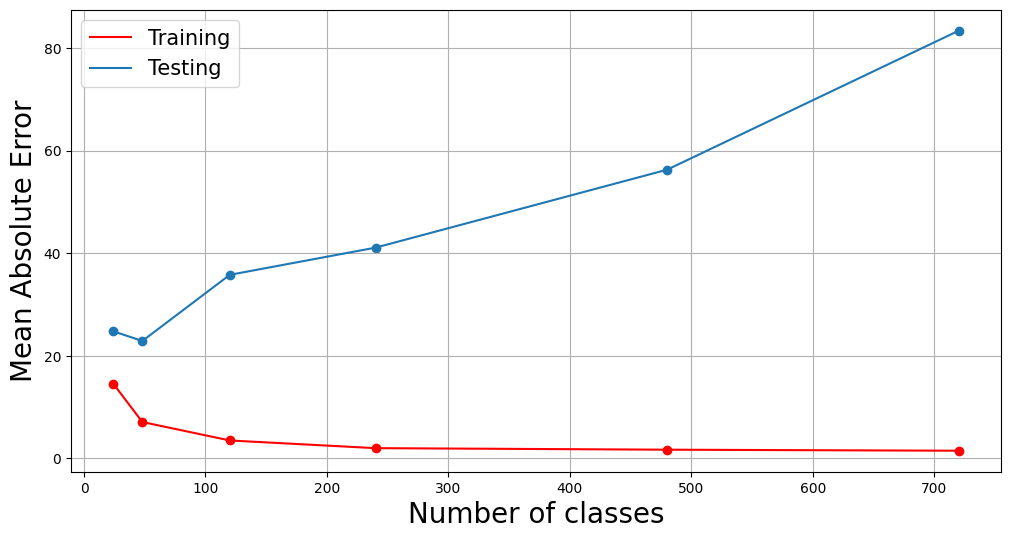

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(classes,train_mae,label='Training',color='red')
plt.scatter(classes,train_mae,color='red')
plt.plot(classes,test_mae,label='Testing')
plt.scatter(classes,test_mae)
plt.grid()
plt.legend(fontsize=15)
plt.xlabel('Number of classes',fontsize=20)
plt.ylabel('Mean Absolute Error',fontsize=20)
plt.savefig('classification.png')
plt.show()